Basic MLP with MNIST data
===========

Import pakages
-----

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install torch
!pip install tensorflow
!pip install torchsummary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
from torchsummary import summary as summary_


Download datas
-----

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

In [8]:
type(mnist)

sklearn.utils._bunch.Bunch

In [3]:
print(mnist.data[0])
print(type(mnist.data[0]))

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0. 

In [4]:
print(mnist.target[0])
print(type(mnist.target[0]))

5
<class 'str'>


Preprocess datas
----

In [5]:
mnist.target = mnist.target.astype(np.int8) # Target이 지금 'str'형으로 되어 있는데 이를 'int'형으로 바꿈

In [6]:
X = mnist.data / 255  # 0-255값을 [0,1] 구간으로 정규화
y = mnist.target

이 이미지 데이터의 레이블은 5이다


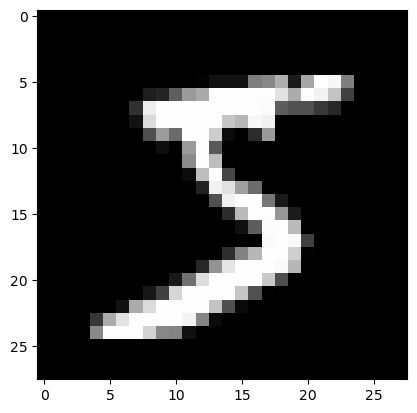

In [7]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 레이블은 {:.0f}이다".format(y[0]))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)

# LongTensor가 data type을 정수형태로 유지해줌
y_train = torch.LongTensor(y_train)  
y_test = torch.LongTensor(y_test)

# Dataset으로 묶어줌
ds_train = TensorDataset(X_train, y_train)  
ds_test = TensorDataset(X_test, y_test)

# Data Loader
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

Construct model
------



In [55]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 25))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(25, 10))

summary_(model,input_size=(28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
              ReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 25]           2,525
              ReLU-4                   [-1, 25]               0
            Linear-5                   [-1, 10]             260
Total params: 81,285
Trainable params: 81,285
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.31
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


In [56]:
from torch import optim

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Choose an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Training Session

```model.train()``` takes the model into training session

- Dropout은 training할 때에는 실행되지만, inference에서는 시행이 되지 않기 때문에 필요함.

In [57]:
def train(epoch):
    
    # Convert the model into Training session 
    model.train()

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, targets in loader_train:

        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정

    print("epoch{}：완료\n".format(epoch))

In [58]:
def test():
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, dim=1, keepdim=False)  # (maximum values, indices)
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 개수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.2f}%)\n'.format(correct,
                                                   data_num, 100. * float(correct) / float(data_num)))
    return float(correct) / float(data_num)

Before training
-----
We can 

In [59]:
test()


테스트 데이터에서 예측 정확도: 914/10000 (9.14%)



0.0914

예측 결과 : 0
이 이미지 데이터의 정답 레이블은 0입니다


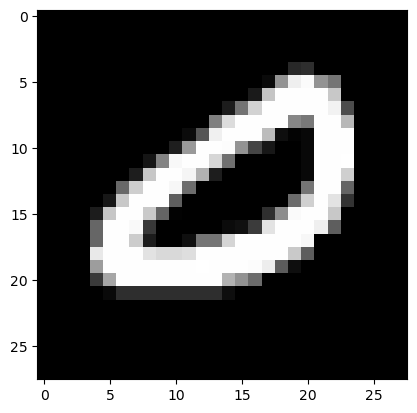

In [60]:
from PIL import Image
model.eval()
index = np.random.randint(10000)

data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산
print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))


Training
-----

In [67]:
acc = []
MAX_ITERATION=30
for epoch in range(MAX_ITERATION):
    train(epoch)
    acc.append(test())


epoch0：완료


테스트 데이터에서 예측 정확도: 9685/10000 (96.85%)

epoch1：완료


테스트 데이터에서 예측 정확도: 9670/10000 (96.70%)



KeyboardInterrupt: 

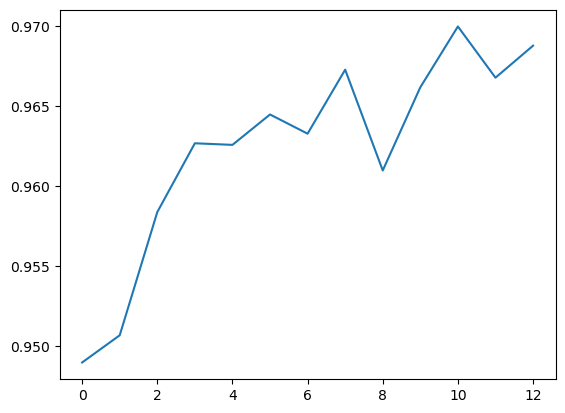

In [62]:
plt.plot(acc)

Check the model with data in testset
------

예측 결과 : 4
이 이미지 데이터의 정답 레이블은 4입니다


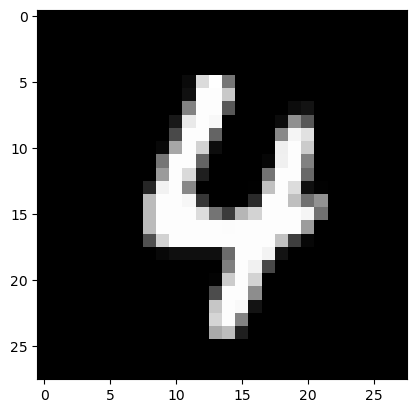

In [63]:
index = 949

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))


Check the model with custom image data
-----


In [69]:
from PIL import Image
model.eval()

img = Image.open('4-1.jpeg').convert("L")
img = np.array(img)
img = img / 255.0
img = 1 - img
print(img)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

예측 결과 : 2


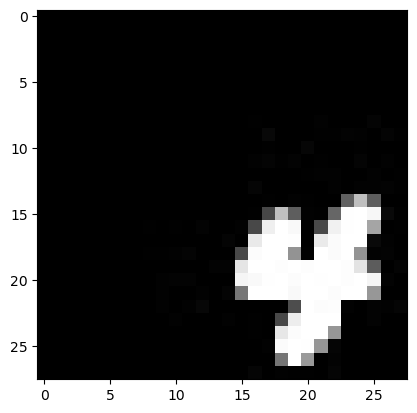

In [70]:
img = img.flatten()


data = torch.tensor(img, dtype=torch.float32)
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산
print("예측 결과 : {}".format(predicted))

plt.imshow(img.reshape(28, 28), cmap='gray')